#  Example: Risk-Aware Binary Bernoulli Bandit Ticker Picker Problem
In this example, we implement ε-greedy sampling to solve a binary Bernoulli bandit problem for selecting stock tickers based on their ability to outperform a market benchmark (SPY).

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> * __Construct bandit and world models for ticker selection:__ Build ε-greedy bandit model instances with success and failure counters for each ticker, implement world functions that return binary rewards based on growth rate comparisons, and configure parameters controlling exploration versus exploitation tradeoffs.
> * __Train bandit agents using historical market data:__ Sample bandit models iteratively over trading horizons to update Beta distributions representing beliefs about ticker performance, visualize evolution of agent beliefs from uniform initial distributions to data-informed final distributions, and interpret probability density functions for ticker preferences.
> * __Aggregate multi-agent preferences into collective recommendations:__ Generate rankings from multiple independent agents, compute frequencies of tickers appearing in top-M groups across agent populations, and construct preference tables showing probability and ordinal rank for each ticker based on collective agent beliefs.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include-practicum.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the dataset by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet).

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"] # load the original dataset (training)

Dict{String, DataFrame} with 515 entries:
  "DD"   => 2329×8 DataFrame…
  "EMR"  => 2767×8 DataFrame…
  "CTAS" => 2767×8 DataFrame…
  "HSIC" => 2767×8 DataFrame…
  "KIM"  => 2767×8 DataFrame…
  "PLD"  => 2767×8 DataFrame…
  "IEX"  => 2767×8 DataFrame…
  "TPR"  => 1803×8 DataFrame…
  "BAC"  => 2767×8 DataFrame…
  "CBOE" => 2767×8 DataFrame…
  "EXR"  => 2767×8 DataFrame…
  "NCLH" => 2767×8 DataFrame…
  "CVS"  => 2767×8 DataFrame…
  "DRI"  => 2767×8 DataFrame…
  "DTE"  => 2767×8 DataFrame…
  "ZION" => 2767×8 DataFrame…
  "AVY"  => 2767×8 DataFrame…
  "EW"   => 2767×8 DataFrame…
  "EA"   => 2767×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers_clean_price_data::Vector{String}` variable:

In [5]:
list_of_tickers_clean_price_data = keys(dataset) |> collect |> sort; # list of tickers in our clean dataset

Next, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable. In addition, we return a few other useful variables, such as the historical market growth rate, the mean and variance of the market growth, etc.

In [6]:
sim_model_parameters,Gₘ,Ḡₘ, Varₘ = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SPY-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    parameters = sim_model_parameters["data"]; # return

    Gₘ = sim_model_parameters["Gₘ"]; # Get the past market growth rate 
    Ḡₘ = sim_model_parameters["Ḡₘ"]; # mean of market growth rates
    Varₘ = sim_model_parameters["Varₘ"]; # variance of market growth

    # return -
    parameters,  Gₘ , Ḡₘ, Varₘ;
end;

In [7]:
sim_model_parameters["UNH"] # display the SIM parameters for Apple Inc. (AAPL)

(ticker = "UNH", n = 2766, p = 2, t = 1.96, alpha = 0.08225175140277917, beta = 0.8612603869027285, alpha_SE = 0.057717895988008416, beta_SE = 0.026880388856255315, alpha_95_CI_lower = -0.03087532473371732, alpha_95_CI_upper = 0.19537882753927566, beta_95_CI_lower = 0.8085748247444682, beta_95_CI_upper = 0.9139459490609889, training_variance = 2316.3917419356617)

Now let's get a list of all tickers for which we have single index model parameters:

In [8]:
tickers_that_we_have_sim_data_for = keys(sim_model_parameters) |> collect |> sort;

We need to use only the tickers for which we have both price data and SIM parameters. We'll compute [the intersection of the two lists](https://docs.julialang.org/en/v1/base/collections/#Base.intersect) and store the result in the `list_of_tickers::Vector{String}` variable:

In [9]:
list_of_tickers = intersect(tickers_that_we_have_sim_data_for, list_of_tickers_clean_price_data)

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 ⋮
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

### Constants and Parameters
Let's define some constants and parameters that we will use in this example. See the comment lines next to each variable for a description of its purpose, units, permissible values, etc.

In [10]:
Δt = (1.0 / 252.0); # time step (in years) between trading days (assumes 252 trading days per year)
risk_free_rate = 0.043; # annualized risk-free interest rate (4.3% per year)
λ = 0; # risk-aversion parameter
number_of_training_steps = 10000; # number of training steps for the bandit agent

### Growth Rate Calculation
Finally, let's compute the daily growth rate time series for all firms in our cleaned dataset using [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix). We store the growth rate time series for each firm in the `all_firms_excess_return_matrix::Array{Float64,2}` variable:

In [11]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

___

## Task 1: Initialize a world model and set up a ticker picker agent
Our first task is to construct models of the bandit agent and the world that this agent samples. We construct [a `MyEpsilonSamplingBanditModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel) to hold agent data and [a `MyTickerPickerSIMRiskAwareWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerSIMRiskAwareWorldModel) to represent the world, both using [custom `build(...)` methods](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTickerPickerSIMRiskAwareWorldModel},%20NamedTuple}).

Specify the list of tickers to examine in the `my_list_of_tickers::Vector{String}` array, and store the number of tickers in the `K::Int64` variable:

In [12]:
my_list_of_tickers, K = let
    
    my_tickers = ["AAPL", "MSFT", "ADBE", "MRK", "PFE", "JNJ", "MET", "NFLX", "AMD", "MU", "NVDA", "INTC", "MMM",
        "UNH", "JPM", "OXY", "TSLA", "PEP", "PG", "UPS", "COST", "TGT", "BAC", "C", "WFC", "KR", "WMT", "GS", "LLY", 
        "AMGN", "CVS", "ABT", "MDT", "HON", "CAT", "DE", "LMT", "BA", "XOM", "CVX"];

    unique!(my_tickers); # ensure uniqueness
    K = length(my_tickers);
    my_tickers, K
end

(["AAPL", "MSFT", "ADBE", "MRK", "PFE", "JNJ", "MET", "NFLX", "AMD", "MU"  …  "CVS", "ABT", "MDT", "HON", "CAT", "DE", "LMT", "BA", "XOM", "CVX"], 40)

In [13]:
K

40

__Check__: Are all the tickers in `my_list_of_tickers` present in the `list_of_tickers` variable defined earlier? If not, modify `my_list_of_tickers` accordingly.

In [14]:
let
    
    # check that all tickers are in our dataset
    for ticker ∈ my_list_of_tickers
        if !(ticker ∈ list_of_tickers)
            error("Ticker $ticker is not in the dataset.")
        end
    end
    println("All $(length(my_list_of_tickers)) tickers are valid and present in the dataset.")
end;

All 40 tickers are valid and present in the dataset.


Next, construct [a `MyEpsilonSamplingBanditModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyEpsilonSamplingBanditModel), which holds information about the [ε-greedy sampling approach](https://arxiv.org/abs/1707.02038). The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyEpsilonSamplingBanditModel},%20NamedTuple}) takes the model type and a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding the number of arms `K::Int64`, initial values for the `α::Vector{Int64}` and `β::Vector{Int64}` arrays (success and failure counters for each arm), and the exploration parameter `ϵ::Float64` controlling the exploration fraction. 

We save the model instance to the `bandit_model::MyEpsilonSamplingBanditModel` variable:

In [15]:
bandit_model = build(MyEpsilonSamplingBanditModel, (
    K = K, # number bandit arms
    α = ones(K), # initialize to uniform values
    β = ones(K), # initialize to uniform values
));

### Setup a MyTickerPickerSIMRiskAwareWorldModel instance

Now that we have the bandit model, construct [a `MyTickerPickerSIMRiskAwareWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerSIMRiskAwareWorldModel) holding world data. The `world(...)` function takes the `start::Int64` index, an action $a\in\mathcal{A}$ value, and the `world_model::MyTickerPickerSIMRiskAwareWorldModel` instance, then returns a binary reward $r\in\left\{0,1\right\}$.

> __Reward Structure:__
>
> We compare the risk-adjusted excess growth rate of ticker $i$ against the mean market excess growth rate $\bar{G}_{m}$. If the ticker's risk-adjusted excess growth rate exceeds the market benchmark, we assign a reward of 1 (success); otherwise, we assign a reward of 0 (failure). The risk-adjustment factor is $\beta_{i}^{\lambda}$, where $\beta$ is the ticker's beta coefficient from the single index model, and $\lambda\in\mathbb{R}_{\geq{0}}$ is the risk-aversion parameter. Higher $\lambda$ values penalize high-beta (risky) assets more severely.

Let's implement the risk-aware world model:

In [16]:
function world(start::Int64, action::Int64, worldmodel::MyTickerPickerSIMRiskAwareWorldModel)::Int64

    # get data from the world model -
    tickers = worldmodel.tickers; # what is my list of tickers?
    parameters = worldmodel.parameters; # single index model parameters
    risk_free_rate = worldmodel.risk_free_rate; # risk-free rate
    Δt = worldmodel.Δt; # time step
    Ḡₘ = worldmodel.Ḡₘ; # mean market growth rate
    buffersize = worldmodel.buffersize; # number of time steps to look ahead
    riskfactors = worldmodel.risk; # risk dictionary
    
    # initialize -
    result_flag = 0;

    # grab the ticker we are looking at
    ticker_symbol = tickers[action];
    RF = riskfactors[ticker_symbol]; # risk factor for this ticker

    # get the SIM parameters for this ticker -
    sim_params = parameters[ticker_symbol];
    αᵢ = sim_params.alpha; # asset i intercept
    βᵢ = sim_params.beta; # asset i sensitivity to market
    TV = sim_params.training_variance; # asset i total variance
    σᵢ = (1/RF)*sqrt(Δt*TV); # asset i standard deviation
    gᵢ = (αᵢ/RF) + (βᵢ/RF)*(Ḡₘ)+(σᵢ*randn()); # adjusted growth rate for asset i    

    # Does this ticker beat the market benchmark?
    (gᵢ > Ḡₘ) ? result_flag = 1 : result_flag = 0;
    return result_flag;
end;

Finally, construct a [`MyTickerPickerSIMRiskAwareWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.MyTickerPickerSIMRiskAwareWorldModel) using [a custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTickerPickerSIMRiskAwareWorldModel},%20NamedTuple}). 

The method takes the model type and a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) with the `my_list_of_tickers::Vector{String}` array, the `data::Dict{String, DataFrame}` field holding price data, the `world::Function`, the `risk_free_rate::Float64`, the time-step $\Delta{t}$, and the `buffersize::Int64` field. 

We store the world model in the `world_model::MyTickerPickerSIMRiskAwareWorldModel` variable:

In [17]:
world_model = let

    # build the risk dictionary -
    risk = Dict{String, Float64}();
    for ticker in my_list_of_tickers
        sim_params = sim_model_parameters[ticker];
        βᵢ = sim_params.beta; # asset i beta (sensitivity to market)
        risk[ticker] = βᵢ^(λ) ; # risk factor based on beta raised to the risk-aversion parameter
    end
    
    # build the world model -
    world_model = build(MyTickerPickerSIMRiskAwareWorldModel, (
        tickers = my_list_of_tickers,
        parameters = sim_model_parameters,
        world = world,
        Ḡₘ = Ḡₘ,
        risk = risk,
        risk_free_rate = risk_free_rate,
        Δt = Δt,
        buffersize = 0, # number of time steps to look ahead
    ));

    world_model; # return
end;

___

## Task 2: Run a single ticker-picker agent and explore its preferences
In this task, we use the world and bandit models to learn ticker preferences for a single agent using [the `sample(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.sample-Tuple{MyEpsilonSamplingBanditModel,%20MyTickerPickerSIMRiskAwareWorldModel}). The function takes the bandit model, world model, and `horizon::Int64` parameter (number of iterations), then returns a dictionary holding [Beta distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta) for each ticker at each time point.

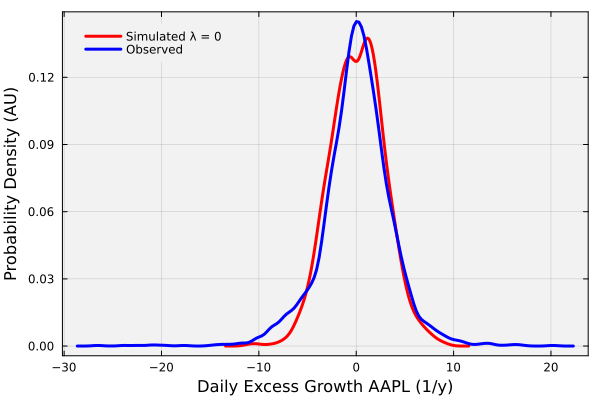

In [18]:
let

    # what decision are we making?
    mytestticker = "AAPL";
    worldmodel = world_model;
    trials = 1000;

    # what is the observed excess return distribution for this ticker?
    Rᵢ = findfirst(x-> x == mytestticker, my_list_of_tickers) |> k-> all_firms_excess_return_matrix[:,k];
    
    # get data from the world model -
    tickers = worldmodel.tickers; # what is my list of tickers?
    parameters = worldmodel.parameters; # single index model parameters
    risk_free_rate = worldmodel.risk_free_rate; # risk-free rate
    Δt = worldmodel.Δt; # time step
    Ḡₘ = worldmodel.Ḡₘ; # mean market growth rate
    buffersize = worldmodel.buffersize; # number of time steps to look ahead
    riskfactors = worldmodel.risk; # risk dictionary
    
    # grab the ticker we are looking at
    ticker_symbol = mytestticker;
    RF = riskfactors[ticker_symbol]; # risk factor for this ticker

    # get the SIM parameters for this ticker -
    sim_params = parameters[ticker_symbol];
    αᵢ = sim_params.alpha; # asset i intercept
    βᵢ = sim_params.beta; # asset i sensitivity to market
    TV = sim_params.training_variance; # asset i total variance
    σᵢ = sqrt(Δt*TV); # asset i standard deviation

    μ = Vector{Float64}(undef, trials);
    for j ∈ 1:trials
        gᵢ = αᵢ/RF + (βᵢ/RF)*(Ḡₘ)+(σᵢ*randn())/RF; # adjusted growth rate for asset i    
        μ[j] = gᵢ;
    end

    density(μ, c=:red, legend = false, lw=3, label="Simulated λ = $(λ)");
    density!(Rᵢ, c=:blue, legend = false, label="Observed", lw=3);
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft);
    xlabel!("Daily Excess Growth $(mytestticker) (1/y)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)

end

The `horizon::Int64` parameter controls the number of consecutive time windows of length `buffersize::Int64` used to train the bandit. We'll set `horizon = number_of_training_steps`:

In [19]:
time_sample_results_dict_eps = sample(bandit_model, world_model; 
    horizon = number_of_training_steps);

To visualize how agent beliefs evolve as more data is encountered, specify a value for the `my_ticker_of_interest::String` variable and find its index using [the `findfirst(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.findfirst-Tuple{Function,%20Any}):

In [20]:
my_ticker_of_interest = "AAPL"; # specify your own ticker here!
index_of_ticker_to_plot = findfirst(x -> x==my_ticker_of_interest, my_list_of_tickers); 

Unhide the code block to see how we visualized agent belief evolution. 

> __What should we expect to see?__ Initially, the agent holds a uniform belief (yellow line) about the ticker outperforming an alternative asset, meaning all beliefs are equally probable. As the agent gathers more data, beliefs become more defined. The progressively darker gray lines illustrate this evolution, with the final belief shown by the thick red line.

Does the bandit learn to prefer this ticker over time?

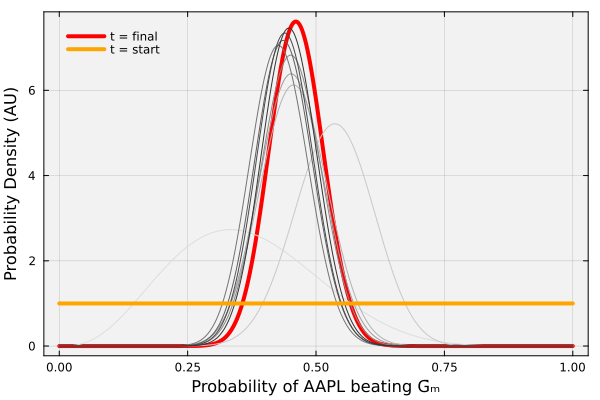

In [21]:
let
    
    # initialize -
    q = plot();
    number_of_trading_periods = length(time_sample_results_dict_eps);
    skip = 1000;
    indexes_to_plot = range(2,number_of_trading_periods - 10,step=skip) |> collect;
    N = length(indexes_to_plot);
    C1 = colorant"gray95"
    C2 = colorant"gray20"
    gray_color_array = range(C1, C2, length=N);

    # initial plot -
    d = time_sample_results_dict_eps[number_of_trading_periods][index_of_ticker_to_plot]
    plot(d, label="t = final", c=:red, lw=4, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft);
    for i ∈ eachindex(indexes_to_plot)
        α = i/N;
        t = indexes_to_plot[i];
        d = time_sample_results_dict_eps[t][index_of_ticker_to_plot]
        plot!(d, label="", c=gray_color_array[i], lw=1)
    end
    d = time_sample_results_dict_eps[1][index_of_ticker_to_plot]
    plot!(d, label="t = start", c=:orange, lw=4)
    xlabel!("Probability of $(my_ticker_of_interest) beating Ḡₘ", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

___

## Task 3: Run a collection of ticker-picker agents and examine their preferences
In this task, we repeat the single-agent analysis with multiple agents by running [the `sample(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.sample-Tuple{MyEpsilonSamplingBanditModel,%20MyTickerPickerSIMRiskAwareWorldModel}) inside a [for-loop](https://docs.julialang.org/en/v1/base/base/#for). We store results at `trading_day_index::Int64` in the `agent_specific_data::Matrix{Beta}` array.

The `agent_specific_data` array holds [Beta distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta) for each agent at `trading_day_index::Int64` for each ticker. Rows represent tickers, and columns represent agents. We use [the `foreach(...)` iteration pattern](https://docs.julialang.org/en/v1/base/collections/#Base.foreach) to populate the array.

In [22]:
number_of_agents = 1000; # how many agents do we want
trading_day_index = number_of_training_steps; # which trading day are we interested in?
agent_specific_data = Matrix{Beta}(undef, K, number_of_agents);

@showprogress dt=1 desc="Computing..." for agent_index ∈ 1:number_of_agents
    
    # sample -
    time_sample_results_dict_eps = sample(bandit_model, world_model; 
        horizon = number_of_training_steps);

    # populate the agent_specific_data array
    foreach(k-> agent_specific_data[k, agent_index] = time_sample_results_dict_eps[trading_day_index][k], 1:K)
end

Computing... 100%|███████████████████████████████████████| Time: 0:02:35


Let's examine the first Beta distribution from `agent = 100`, which holds agent perceptions encoded as [Beta distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta):

In [23]:
agent_specific_data[:,10][1]

Beta{Float64}(α=148.0, β=153.0)

### Compute the wisdom of the collective
Now that we have agent preferences encoded as Beta distributions, let's develop a consensus belief about which tickers to include in portfolio $\mathcal{P}$. Compute the agent-specific rank of each ticker, where `rank = 1` is best and `rank = K` is worst, and store values in the `preference_rank_array::Array{Int,2}` array.

The challenge is transforming the collective perception, encoded as [Beta distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta), into ticker recommendations.

In [24]:
preference_rank_array = Matrix{Int}(undef, number_of_agents, K);
for agent ∈ 1:number_of_agents
        
    # ask an agent about their preference for ticker i
    experience_distributions = agent_specific_data[:,agent]
    preference_vector = preference(experience_distributions, my_list_of_tickers) .|> x-> trunc(Int64, x) # wow the trunc function is cool!

    # package
    foreach(i -> preference_rank_array[agent, i] = preference_vector[i], 1:K);
end
preference_rank_array

1000×40 Matrix{Int64}:
 13   4  14  40  26  11  24   5  34  …   7  33   6  32  19  15   9  29  28
 21   5   3  20  36  31  18  30  10     27  23  15   6  12  33  16  18  32
 13  37  27  25  23  24  39  33  15      3  34   7  32  20   2  29  17  34
 15   4   6  18  39   3  36  26   1     30  17  38   9  23  27  12  24  20
  6  35  14  36  27  22  10  17  12     30  34  17  30  25  20  28  15   3
 26  12  15   5  21  33  39  27   3  …  37  35  34  31  40  18  11  22  24
  2  16   4  18  34   7  10  38  11     22   8  27  36  17  31  21  24  23
  8  13  30  24  16   3  30   4   7     38  27  18  37  20  32  11  15  28
  4  21  29  19  28  30  27   3  17     25  35  38  37  33  13   5  22  39
 21   2  20  19  18  23  28  12  14     15   8  17  29  34  33  30  10  11
  ⋮                   ⋮              ⋱                   ⋮              
 26  27  35  28  34  30  36   6  15     21  28  39   4  24  20  38  40  25
  3  34  15  28  23  30  36  12   6     37   7  11  33  40  20  27   9  35
 13 

#### What's in the preference_rank_array?
The rows of the `preference_rank_array::Matrix{Int}` correspond to agents, while the columns correspond to tickers. Each entry holds that agent's ranking for that ticker, with smaller values indicating higher preference. Rankings were calculated [using the `preference(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#VLQuantitativeFinancePackage.preference), which takes agent beliefs encoded as [Beta distributions](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta) and returns ordinal rankings.

> __Strategy:__ Let's count how many times each ticker appears in the top M firms across all agents, then normalize to estimate the probability of top-M ranking using a [for-loop](https://docs.julialang.org/en/v1/base/base/#for). First, set a value for `M::Int64`, the number of top firms to consider. Store probabilities in the `probability_top_dictionary::Dict{String, Float64}`.

The code makes heavy use of [the pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to condense operations.

In [25]:
M = 20; # look for top M firms
probability_top_dictionary = Dict{String,Float64}();
for i ∈ eachindex(my_list_of_tickers)
    probability = findall(x-> x ≤ M, preference_rank_array[:,i]) |> x -> length(x) |> x-> x/number_of_agents; # compute probability
    my_list_of_tickers[i] |> ticker -> probability_top_dictionary[ticker] = probability; # store probability
end

Build a preference table over the population of agents.
The `probability_top_dictionary::Dict{String, Float64}` holds the probability each ticker is ranked in the top M.

Unhide the code block to see how we constructed the preference table using [the `ordinalrank(...)` function from StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) and [PrettyTables.jl](https://github.com/ronisbr/PrettyTables.jl).

* The preference table shows which tickers are most frequently ranked in the top M across all agents. Tickers with higher probabilities (closer to 1.0) are more consistently selected by the agent population.
* __Note:__ Because the problem is stochastic, results will vary between runs. Increasing the number of agents `number_of_agents::Int64` improves convergence and stability at the expense of computational efficiency.

Let's interpret these results more deeply:

> __Interpretation:__ Tickers with high preference (small ranks and high probabilities) are more likely to beat a alternative investment, while low-ranked tickers may not outperform over repeated investment periods. However, we have not considered market dynamics, e.g., the change in the expected excess growth rate of the market factor over time, nor have we accounted for uncertainty in our single index model parameters.

so what do we see?

In [26]:
let
    # initialize 
    df = DataFrame();
    tmp = Vector{Float64}();
    riskfactors = world_model.risk; # risk dictionary

    # compute the ordinal rank of the sorted list of tickers
    my_sorted_tickers = my_list_of_tickers |> sort;
    foreach(ticker -> push!(tmp, probability_top_dictionary[ticker]), my_sorted_tickers)
    ordinal_rank = ordinalrank(tmp, rev=true); # function exported by StatsBase.jl
    
    # populate rows in the df -
    for i ∈ eachindex(my_sorted_tickers)
        ticker_value = my_sorted_tickers[i];  
        beta = sim_model_parameters[ticker_value].beta; # get beta for this ticker  
        alpha = sim_model_parameters[ticker_value].alpha; # get alpha for this ticker
        rage = alpha/(beta^λ) + (beta^(1-λ))*Ḡₘ; # risk-adjusted growth estimate
        ge = alpha + beta*Ḡₘ; # expected growth estimate
        freq_value = probability_top_dictionary[ticker_value];
        row_df = (
            ticker = ticker_value,
            probability = freq_value,
            rank = ordinal_rank[i],
            lambda = λ,
            beta = beta,
            riskmultiplier = riskfactors[ticker_value],
            ge = ge,
            rage = rage
        );
        push!(df, row_df);
    end
    
    pretty_table(
        df;
        fit_table_in_display_vertically = false,
        fit_table_in_display_horizontally = false,
        backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- ------------- ------- -------- ---------- ---------------- ------------ ------------
  ticker   probability    rank   lambda       beta   riskmultiplier           ge         rage 
  String       Float64   Int64    Int64    Float64          Float64      Float64      Float64 
 -------- ------------- ------- -------- ---------- ---------------- ------------ ------------
    AAPL         0.693       2        0    1.19459              1.0     0.232801     0.232801
     ABT          0.49      20        0   0.850069              1.0    0.0979498    0.0979498
    ADBE         0.606       9        0    1.26403              1.0     0.183571     0.183571
     AMD         0.651       5        0    1.73915              1.0      0.31199      0.31199
    AMGN         0.464      23        0   0.726034              1.0    0.0747066    0.0747066
      BA         0.457      24        0    1.52652              1.0    0.0229642    0.0229642
     BAC         0.491      19        0    1.35942      

Ultimately, it remains unclear how to construct portfolios from these preferences for risk-blind or risk-aware agents. There are many questions to explore, for example, how do we incorporate dynamic market conditions, or determine the relative amounts asset $i$ and $j$ to hold in the portfolio. __These questions would make an interesting practicum problem?__

Yes, they would, and they are! So let's save the ticker-picker preferences for use in the practicum problem solution template. The code block below saves the `df::DataFrame` variable holding the preference table to a `.jld2` file for later use.

In [27]:
let

    # initialize 
    df = DataFrame();
    tmp = Vector{Float64}();
    riskfactors = world_model.risk; # risk dictionary
    path_to_save_file = joinpath(_PATH_TO_DATA, "Ticker-Picker-Preferences-Neutral-Fall-2025.jld2");

    # compute the ordinal rank of the sorted list of tickers
    my_sorted_tickers = my_list_of_tickers |> sort;
    foreach(ticker -> push!(tmp, probability_top_dictionary[ticker]), my_sorted_tickers)
    ordinal_rank = ordinalrank(tmp, rev=true); # function exported by StatsBase.jl
    
    # populate rows in the df -
    for i ∈ eachindex(my_sorted_tickers)
        ticker_value = my_sorted_tickers[i];  
        beta = sim_model_parameters[ticker_value].beta; # get beta for this ticker  
        alpha = sim_model_parameters[ticker_value].alpha; # get alpha for this ticker
        rage = alpha/(beta^λ) + (beta^(1-λ))*Ḡₘ; # risk-adjusted growth estimate
        ge = alpha + beta*Ḡₘ; # expected growth estimate
        freq_value = probability_top_dictionary[ticker_value];
        row_df = (
            ticker = ticker_value,
            probability = freq_value,
            rank = ordinal_rank[i],
            lambda = λ,
            beta = beta,
            riskmultiplier = riskfactors[ticker_value],
            ge = ge,
            rage = rage
        );
        push!(df, row_df);
    end

    # save the data to a JLD2 file in the data folder -
    save(path_to_save_file, Dict("preferences" => df, 
        "λ" => λ, "number_of_agents" => number_of_agents, "cutoff_rank_M" => M));
end

___

## Summary

In this example, we implemented a risk-aware version of the binary Bernoulli bandit problem to select portfolios of tickers that beat the market benchmark (SPY).
Key takeaways include:

- **Risk-adjusted returns matter:** A ticker's ability to outperform the market benchmark depends on both its alpha and its systematic risk (beta).
- **Risk-aversion changes preferences:** Agents with higher risk-aversion prefer tickers with lower systematic risk, even if they have slightly lower expected returns.
- **ε-greedy learning works:** The ε-greedy algorithm efficiently explores the space of tickers and converges to a preference for tickers that provide good risk-adjusted returns relative to the market benchmark.
- **Agent heterogeneity:** Different agents with different risk preferences select different portfolios, demonstrating the importance of personalizing investment strategies to individual risk tolerance.

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___